In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import morphology, measure
from skimage import filters, color
import os
import cv2
import random
import tqdm.auto as tqdm
from functools import partial
import csv
from PIL import Image, ImageDraw

In [175]:
DATA_DIR = os.path.join('..', 'data')
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
FEATURES_DIR = os.path.join(DATA_DIR, 'features')
POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'
TAGGED_IMAGES_PATH = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')

USE_CACHE = False
PLOT_RESULTS = False
SEED = 2
random.seed(SEED)

## METODOS

Contiene funciones y clases necesarias para la ejecucion del notebook.

### ANALISIS

In [176]:
from matplotlib import colors

def scatter_plot_rgb(imag, axs=None):
    r, g, b = cv2.split(imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()

    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1,1,1, projection="3d")

    axs.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Red")
    axs.set_ylabel("Green")
    axs.set_zlabel("Blue")
    axs.set_title("RGB Scatter Plot")

def scatter_plot_hsv(imag, axs=None):
    hsv_imag = cv2.cvtColor(imag, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_imag)
    pixel_colors = imag.reshape((np.shape(imag)[0]*np.shape(imag)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    if axs is None:
        fig = plt.figure()
        axs = fig.add_subplot(1,1,1, projection="3d")
    axs.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axs.set_xlabel("Hue")
    axs.set_ylabel("Saturation")
    axs.set_zlabel("Value")
    axs.set_title("HSV Scatter Plot")
    return hsv_imag

### UTILIDADES

In [177]:
def interpolate_image_size(image, prop_size, interpolation):
    ''' 
    Increase/decrease the size of the image by a given proportion, using the given interpolation method
    '''
    height, width = (image.shape[:2])
    return cv2.resize(image, (int(width), int(height)), interpolation=interpolation)


def draw_mask_contour(image, mask):  
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = image.copy()
    cv2.drawContours(out, contours, -1, (0,255,0), 1)
    return out

class pipeline:
    def __init__(self) -> None:
        self.operations = []
    
    def __repr__(self):
        operation_names = [op.__name__ for op in self.operations][::-1]
        par = [')' for _ in range(len(self.operations) - 1)]
        return f"ImageProcessingPipeline: {'('.join(operation_names)}(image{''.join(par)})"

    def add_operation(self, operation):
        self.operations.append(operation)
    
    def remove_operation(self, operation):
        self.operations.remove(operation)
    
    def apply(self, image, verbose=False):
        img = image.copy()
        if verbose:
            #print(str(self))
            plt.figure()
            plt.title("Original")
            plt.imshow(img)
            plt.show()
        for operation in tqdm.tqdm(self.operations, desc="Processing", unit="operation",disable=True):
            img = operation(img)
            if(verbose):
                plt.figure()
                #plt.title(operation.__name__)
                plt.imshow(img)
                plt.show()
        return img

### MEDIDAS

In [218]:
def image_matching(image, mask): # TODO: ARREGLAR USANDO LO MISMO QUE EN JACCARD
    """
    This function computes the matching of the image by the mask
    """
    intersection = np.sum(np.where(image * mask > 0, 1, 0))
    return intersection / np.sum(np.where(mask > 0, 1, 0))

def jaccard_index(imagen_referencia, imagen_segmentacion):
    # Convertir las imágenes a arreglos NumPy binarios
    referencia_binaria = np.asarray(imagen_referencia).astype(bool)
    segmentacion_binaria = np.asarray(imagen_segmentacion).astype(bool)

    # Calcular el tamaño de la intersección y la unión
    interseccion = np.logical_and(referencia_binaria, segmentacion_binaria)
    union = np.logical_or(referencia_binaria, segmentacion_binaria)

    # Calcular el índice de Jaccard
    jaccard = np.sum(interseccion) / np.sum(union)

    return jaccard

def test_mask_results(results_path, pipe: pipeline):
    results = []
    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:
            print (row["filename"])
            imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', row["filename"]))            
            binary = pipe.apply(imag, False)
            #binary = interpolate_image_size(binary, prop_size=0.25, interpolation=cv2.INTER_CUBIC)

            region_attr = eval(row["region_shape_attributes"])
            shape_teo = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))
            mask_teo = Image.new("RGB", binary.shape, "black")
            dibujo_teo = ImageDraw.Draw(mask_teo)
            dibujo_teo.polygon(shape_teo, outline="white", fill="white")
            mask_teo = cv2.cvtColor(np.array(mask_teo), cv2.COLOR_RGB2GRAY)

            results.append(jaccard_index(mask_teo, binary))
    return results

### SEGMENTADORES

In [225]:
def otsu_threshold(image):
    gray = color.rgb2gray(np.array(image))
    threshold = filters.threshold_otsu(gray)
    return gray > threshold

def simple_threshold(gray, threshold=0):
    return gray > threshold

def kmeans_segmentation(image, k = 3):
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    
    # reshape data into the original image dimensions
    segmented_image = segmented_data.reshape((image.shape))
    
    return segmented_image

def kmeans_segmentation2(image_bgr, k = 3):
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
    
    # Perform the k-means clustering
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # convert data into 8-bit values
    centers = np.uint8(centers)
    res = [image_bgr]
    for i in range(k):
        temp = np.zeros(centers.shape, np.uint8)
        temp[i] = centers[i]
        res.append((temp[labels.flatten()]).reshape((image.shape)))
    return res, centers

def keep_most_blue_component(kmeans_results, Print=False):
    res, _ = kmeans_results
    blue_mask = simple_threshold(to_grayscale(keep_blue(res[0], False)))
    max_jaccard = 0
    blue_mask_res = None
    for i in range(1, len(res)):
        temp = simple_threshold(to_grayscale(res[i]))
        jaccard = jaccard_index(blue_mask,temp)
        if jaccard > max_jaccard:
            max_jaccard = jaccard
            blue_mask_res = res[i]
    if(Print):
        plt.imshow(blue_mask_res)
        plt.title("Blue mask result")
        plt.show()
    if blue_mask_res is None:
        print('no mask')
        return res[i]
    return blue_mask_res
        

def morfology_cleaning(image):
    cleaned = morphology.remove_small_objects(image, min_size=200)
    return cleaned

def morfology_absorption(image, size=5):
    absorption = morphology.binary_dilation(image, morphology.disk(size))
    absorption = morphology.binary_erosion(absorption, morphology.disk(size))
    return absorption

def morfology_closing(binary):
    binaryInt8 = binary.astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    binaryInt8 = cv2.morphologyEx(binaryInt8, cv2.MORPH_CLOSE, kernel)
    return binaryInt8

def keep_blue(image, Print=False):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_blue = np.array([90,50,50])
    upper_blue = np.array([250,255,255])

    # blue color mask
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    res = cv2.bitwise_and(image,image, mask= mask)

    if(Print):
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax1.imshow(image_rgb)
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(mask, cmap='gray')
        ax3 = fig.add_subplot(1, 3, 3)
        res_rgb = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
        ax3.imshow(res_rgb)
    return res

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

### Medición

In [180]:
def print_metrics(binary):
    # Label the largest object in the image
    labels = measure.label(binary)
    largest_object = np.argmax(np.bincount(labels.flat)[1:]) + 1

    # Create a mask 
    pool_mask = labels == largest_object

    props = measure.regionprops(pool_mask.astype(int))
    prop = props[0]
    area = prop.area  
    perimeter = prop.perimeter  

    # Eccentricity of the ellipse equivalent to the region. This is the ratio of the distance between the foci of the ellipse 
    # and its major axis length. The value is in the interval [0, 1). When it is 0, the ellipse becomes a circle.
    eccentricity = prop.eccentricity
    equivalent_diameter = prop.equivalent_diameter  # in pixels

    print( "Area: ", area)
    print( "Perimeter: ", perimeter)
    print( "Eccentricity: ", eccentricity)
    print( "Equivalent Diameter: ", equivalent_diameter)

def display_image_mask(image, mask, title=None):
    if title:
        print()
        print(title)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axs[0].matshow(image)
    axs[1].matshow(mask, cmap='gray')
    axs[0].set_title("Original")
    axs[1].set_title("Processed")
    plt.axis('off')
    plt.show()

def obtain_measured_mask(img_name, results_path, mask_shape):
    '''
    This function obtains the mask of the image with the given name from the results path
    '''
    with open(results_path, 'r') as results_csv:
        reader_csv = csv.DictReader(results_csv)
        for row in reader_csv:
            if row['filename'] == img_name:
                region_attr = eval(row["region_shape_attributes"])
                mask_verts = list(zip(region_attr['all_points_x'], region_attr['all_points_y']))

                mask = Image.new("RGB", mask_shape, "black")
                mask_draw = ImageDraw.Draw(mask)
                mask_draw.polygon(mask_verts, outline="white", fill="white")
                mask = cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY)
                
                return mask

## Espacio de color

A continuacion se observa el espacio de color RGB y HSV para una muestra de imagene con piscina. Es interesante observar como en el espacio de color HSV, la ...

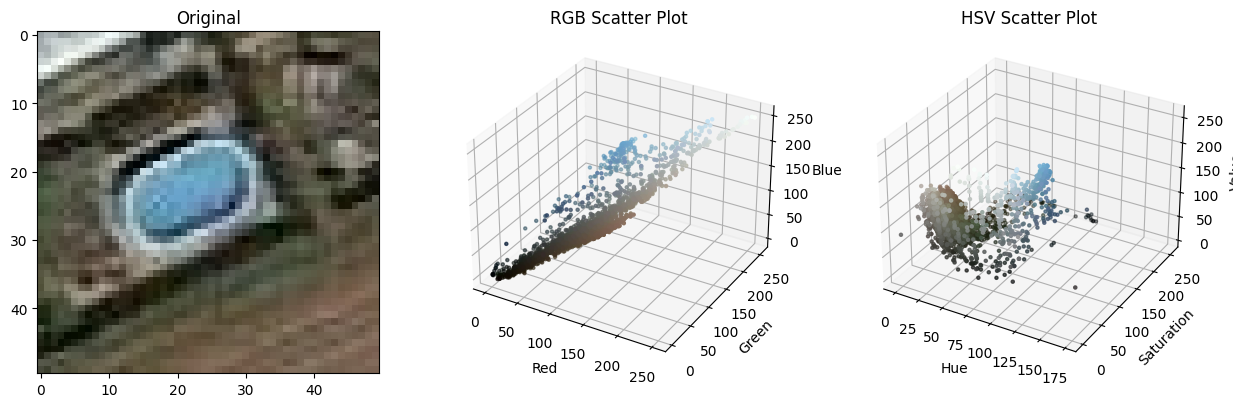

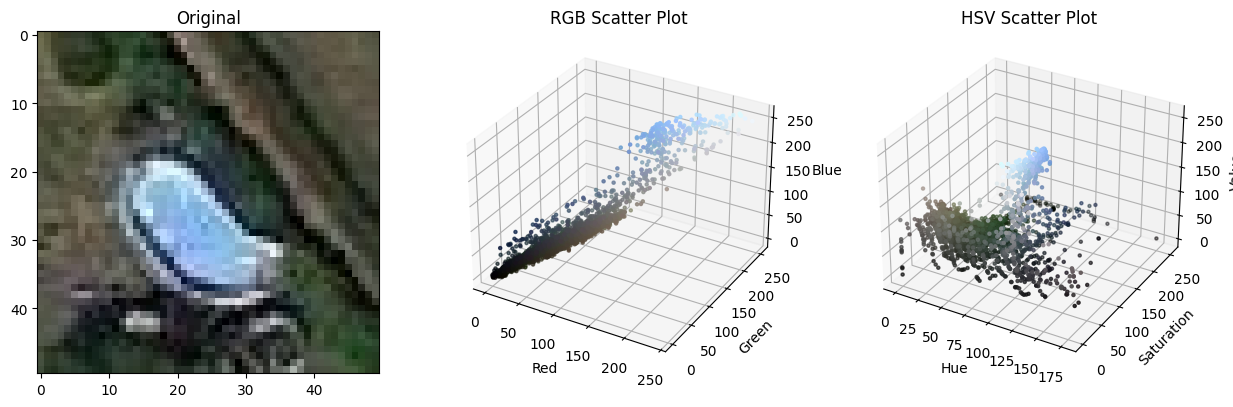

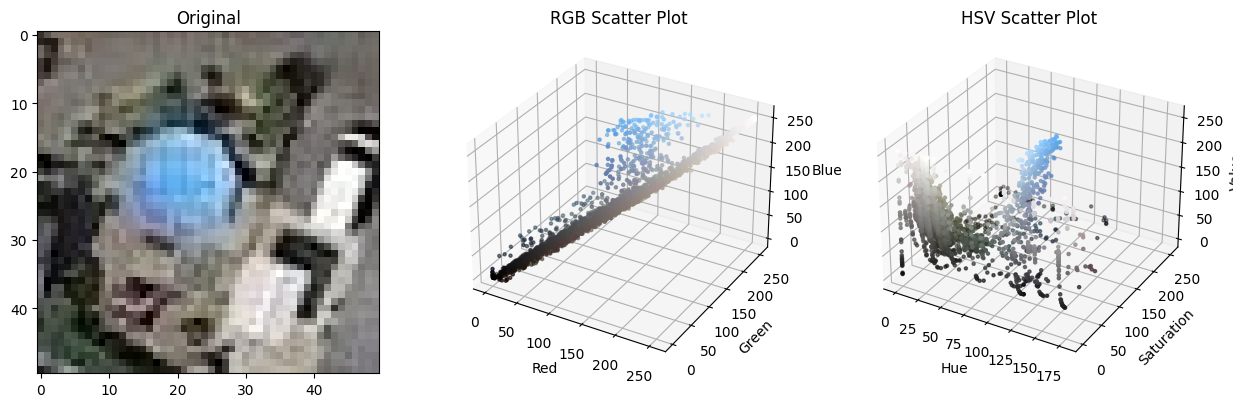

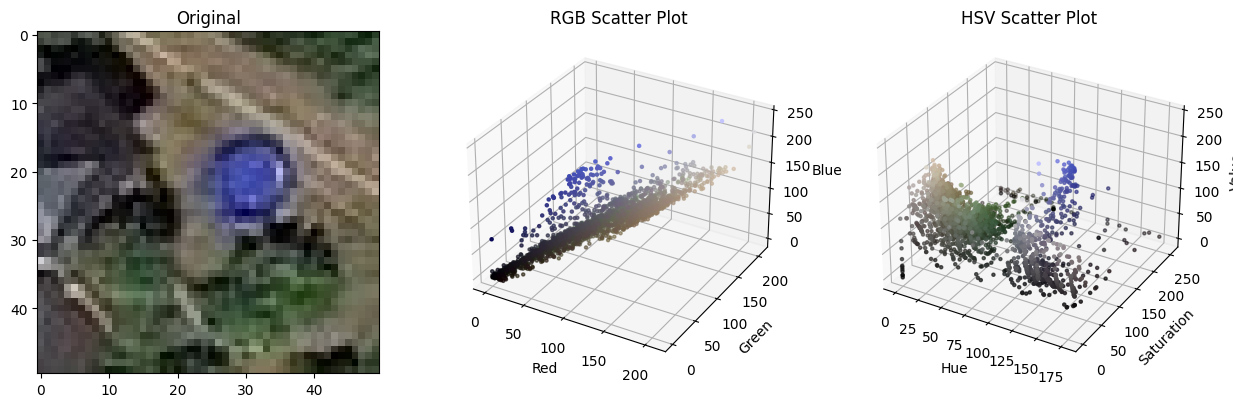

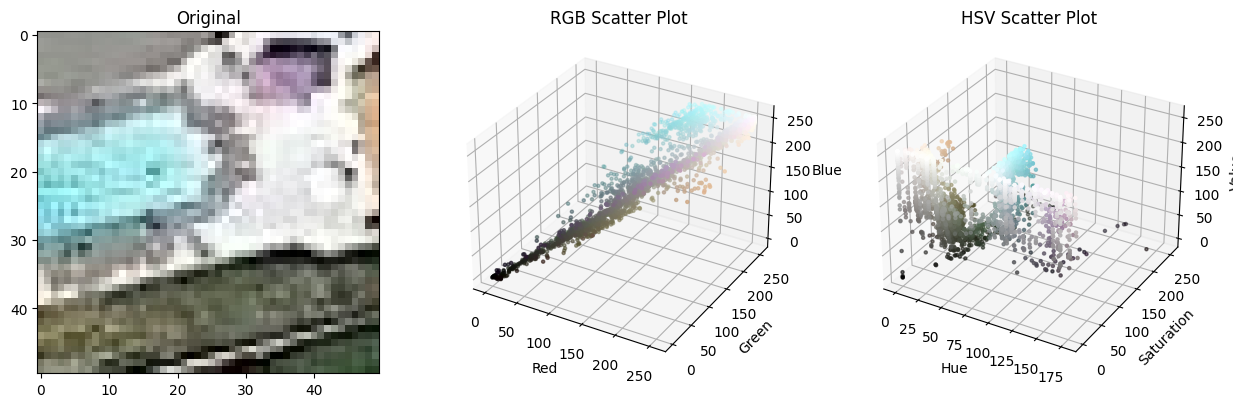

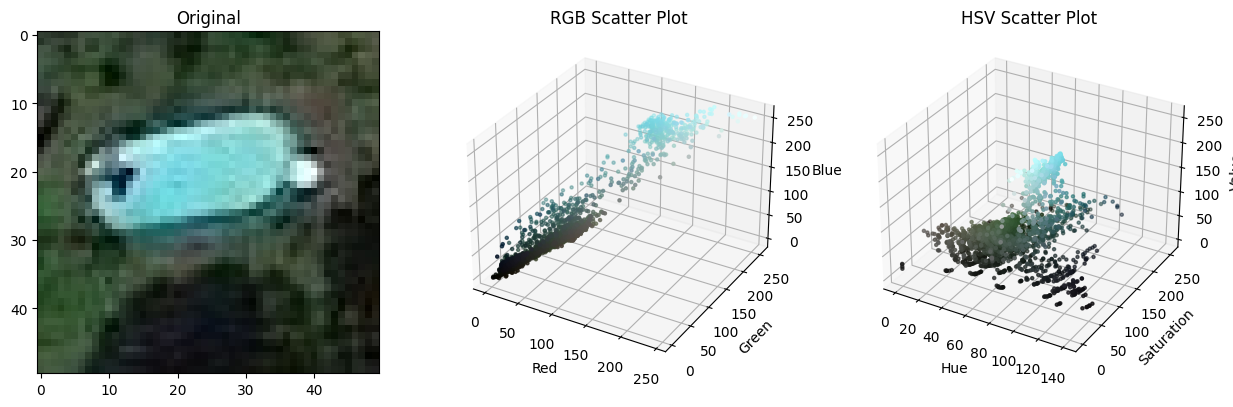

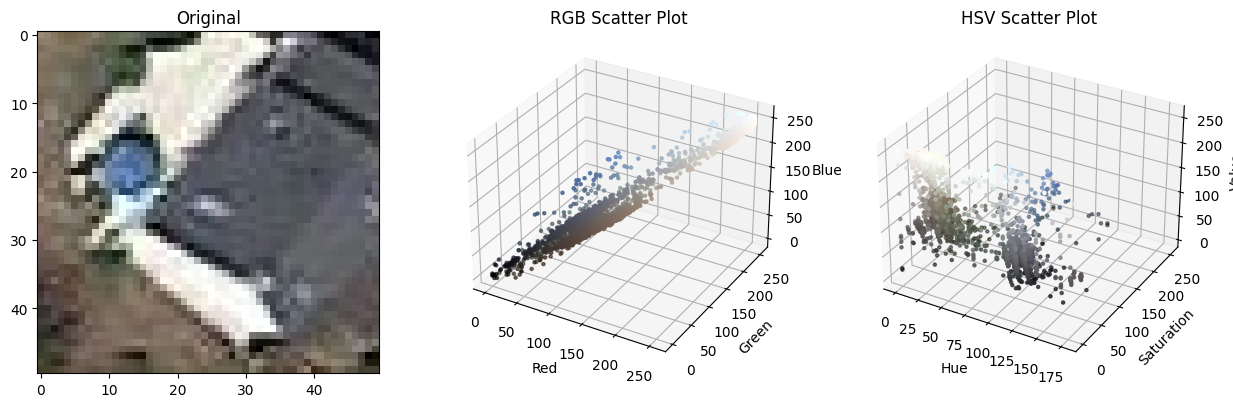

In [181]:

images = ['img29.jpg','img0.jpg', 'img1.jpg', 'img11.jpg','img16.jpg', 'img1454.jpg', 'img680.jpg']

light_blue = (250,255,255)
dark_blue = (90,50,50)

lo_square = np.full((10, 10, 3), light_blue, dtype=np.uint8)
do_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8)

lo_square_rgb = cv2.cvtColor(lo_square, cv2.COLOR_BGR2RGB)
do_square_rgb = cv2.cvtColor(do_square, cv2.COLOR_BGR2RGB)

for image_name in images:
    imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', image_name))
    
    image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(image_rgb)
    ax1.set_title("Original")
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    scatter_plot_rgb(image_rgb.copy(), ax2)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    scatter_plot_hsv(image_rgb.copy(), ax3)
    #keep_blue(imag, True)
    plt.show()

## Segmentadores


En esta seccion se mostraran algunas estrategias que fueron utilizadas para intentar segmentar las piscinas, se compararan los resultados obtenidos ya sea entre ellos, como contra algunas mascaras previamente generadas manualmente utilizando la herramienta VGG.

### KEEP_BLUE

TODO: Descripcion RESULTADOS


ImageProcessingPipeline: morfology_closing(simple_threshold(to_grayscale(keep_blue(image))))


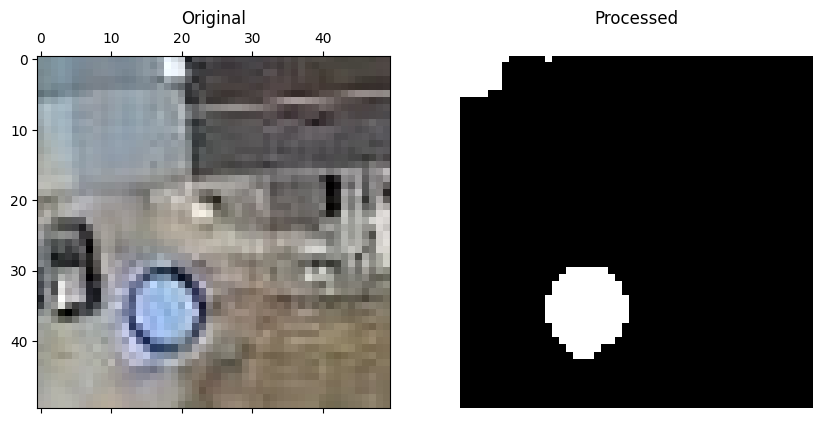

Indice de Jaccard:  0.6363636363636364
Cobertura de imagen: 0.9051724137931034

ImageProcessingPipeline: morfology_closing(simple_threshold(to_grayscale(keep_blue(image))))


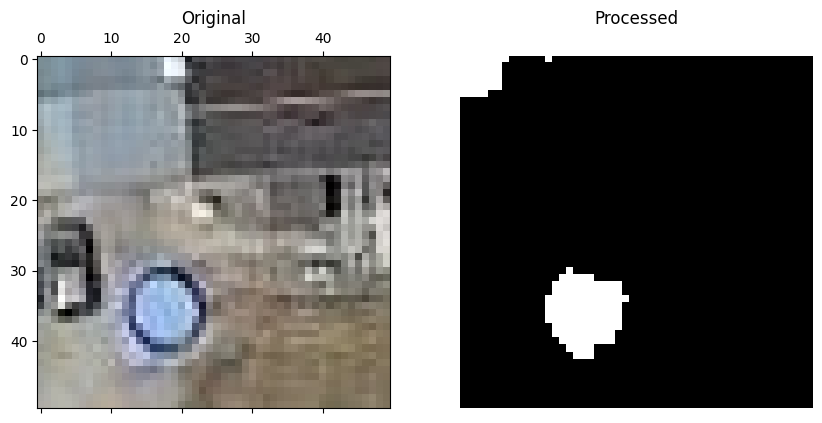

Indice de Jaccard:  0.5670731707317073
Cobertura de imagen: 0.8017241379310345


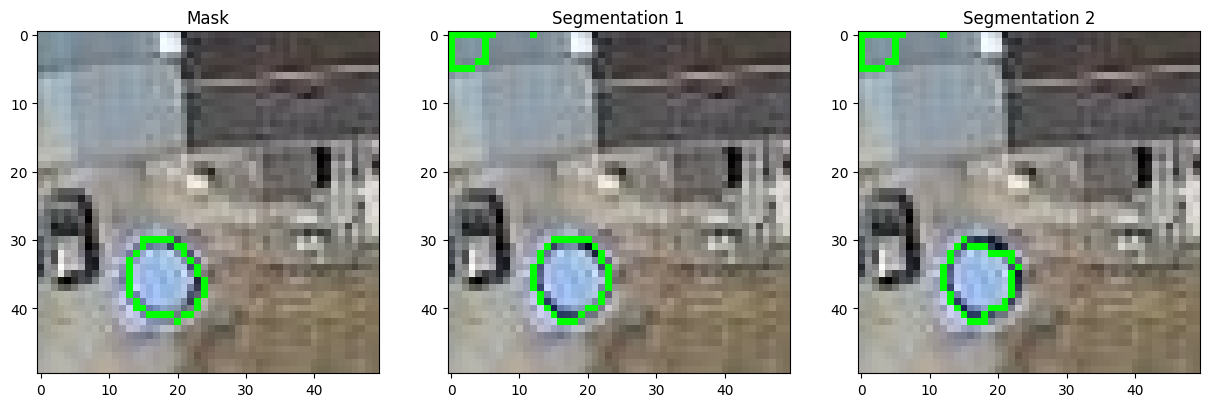

In [226]:
image_bgr = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img25.jpg'))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
mask = obtain_measured_mask('img25.jpg', TAGGED_IMAGES_PATH, gray.shape)

pipe = pipeline()
pipe.add_operation(keep_blue)
pipe.add_operation(to_grayscale)
pipe.add_operation(simple_threshold)
pipe.add_operation(morfology_closing)
binary = pipe.apply(image_bgr, False)
display_image_mask(image_rgb, binary, title=pipe)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))


pipe2 = pipeline()
pipe2.add_operation(keep_blue)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_closing)
binary2 = pipe2.apply(image_bgr, False)
display_image_mask(image_rgb, binary2, title=pipe)
print('Indice de Jaccard: ', jaccard_index(mask, binary2))
print('Cobertura de imagen:', image_matching(binary2, mask))


image_mask = draw_mask_contour(image_rgb, mask)
image_segmentation1 = draw_mask_contour(image_rgb, binary)
image_segmentation2 = draw_mask_contour(image_rgb, binary2)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].imshow(image_mask)
axs[0].set_title("Mask")
axs[1].imshow(image_segmentation1)
axs[1].set_title("Segmentation 1")
axs[2].imshow(image_segmentation2)
axs[2].set_title("Segmentation 2")
plt.show()


TODO: agrear alguna imagen mas

### OTSU THRESHOLDING

TODO: Descripcion RESULTADOS / AGRER  COMENTAR QUE PARA ALGUNOS SI DA BIEN

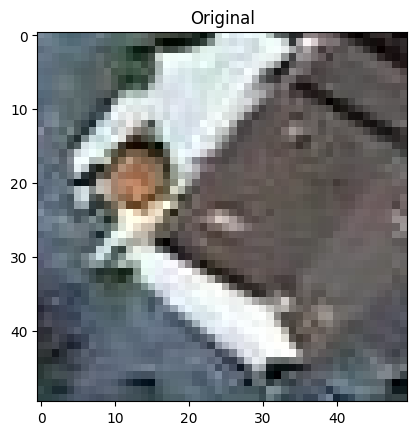

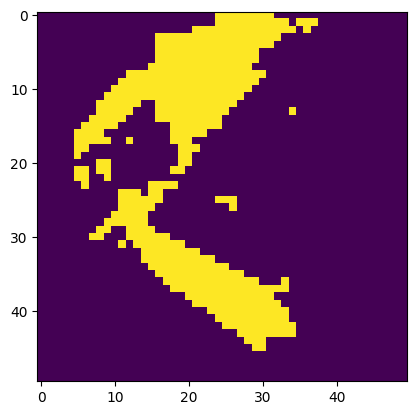

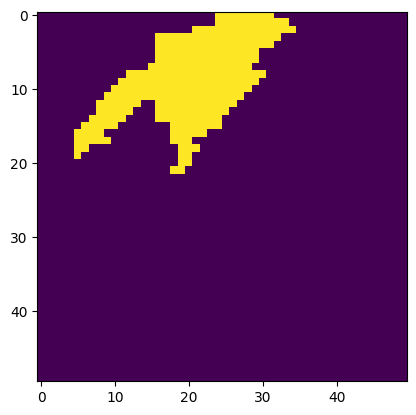

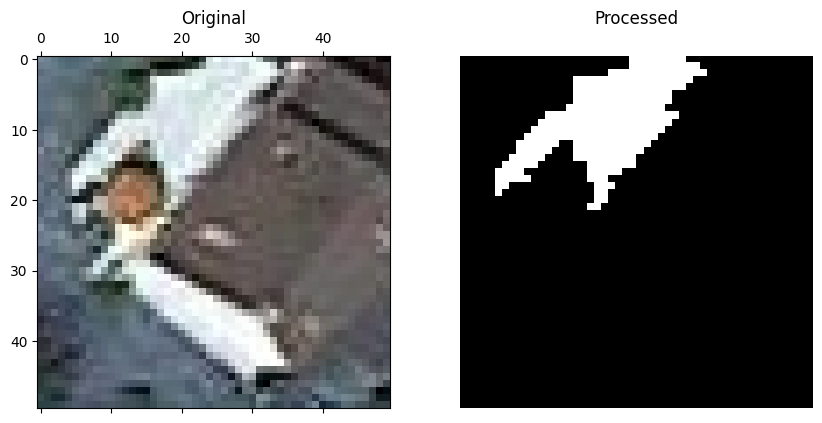

In [183]:
pipe3 = pipeline()
pipe3.add_operation(otsu_threshold)
pipe3.add_operation(morfology_cleaning)
binary = pipe3.apply(imag, True)
display_image_mask(imag, binary)

Al aplicar segmentación omitiendo el paso de k-means para separación de componentes, el resultado es un poco peor que en el caso anterior, ya que se pierden algunos detalles durante la separación de la piscina. Esto se refleja en una cobertura que es menos exacta en lo que refiere a ajustarse al área de la piscina, ya que no tiene en cuenta la forma de la misma obtenida por k-means en el caso anterior, disminuyendo el indice de Jaccard dado. Sin embargo, en este caso esto también termina causando que se incluyan más detalles que en el caso en que se usa k-means, lo que se puede observar en el índice de cobertura obtenido.

### KMEANS (HSV)

### KMEANS (RGB)

#### K-means simple


ImageProcessingPipeline: kmeans_segmentation(image)


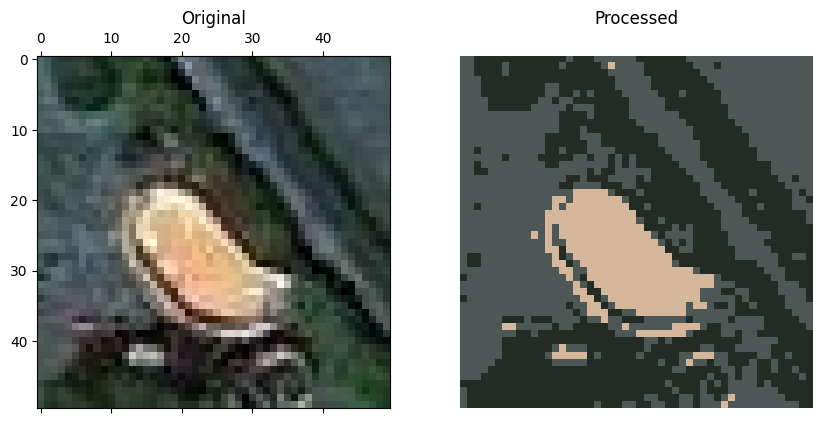

In [234]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
segmented = pipe1.apply(imag, False)
display_image_mask(imag, segmented, title=pipe1)

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
mask = obtain_measured_mask('img0.jpg', results_path, gray.shape)

#### K-means con otsu thresholding

En los resultados anteriores se muestra la aplicación de segmentación mediante el algoritmo K-means, con un posterior uso del método de Otsu para thresholding para seleccionar la componente deseada entre las devueltas por K-means. Se puede observar que el resultado es bastante bueno, ya que se llega a separar la piscina de forma aproximada. Se observa también que este resultado de segmentación incluye bastantes detalles no deseados, que pueden verse evaluando el índice de Jaccard obtenido.


ImageProcessingPipeline: otsu_threshold(kmeans_segmentation(image))


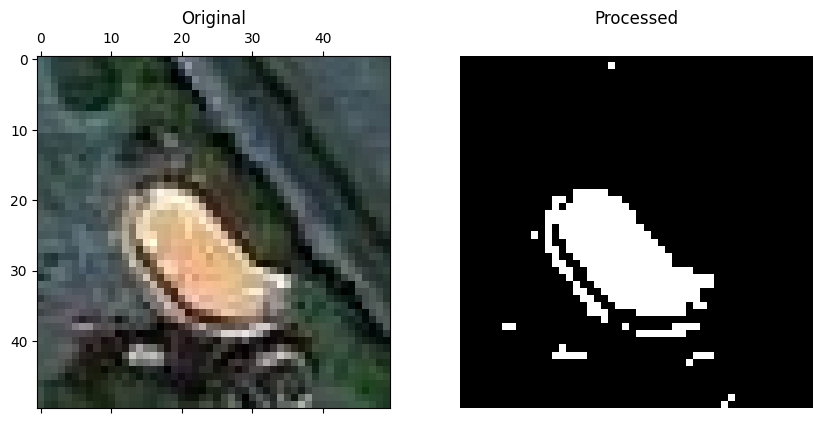

Indice de Jaccard:  0.6360759493670886
Cobertura de imagen: 0.8305785123966942


In [185]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img0.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)


pipe1 = pipeline()
pipe1.add_operation(kmeans_segmentation)
pipe1.add_operation(otsu_threshold)
binary = pipe1.apply(imag, False)
display_image_mask(imag, binary, title=pipe1)

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
mask = obtain_measured_mask('img0.jpg', results_path, gray.shape)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

#### K-means con otsu thresholding y eliminación de ruido

Al agregar un paso de eliminación de ruido, se puede observar que el resultado mejora considerablemente, ya que se eliminan los detalles no deseados. Esto se puede observar en el aumento del índice de Jaccard, así como en la propia máscara obtenida. Esto se debe a que la mayoría de los detalles no deseados son de un tamaño menor al del kernel utilizado para la eliminación de ruido mediante erosión/dilatación. Se refleja este resultado en el aumento del índice de Jaccard obtenido, que significa que se llegó a una aproximación más exacta de la imagen. A su vez, la disminución leve del indice de cobertura significa que la mayoría de los detalles eliminados no son parte de la piscina.


ImageProcessingPipeline: morfology_cleaning(otsu_threshold(kmeans_segmentation(image)))


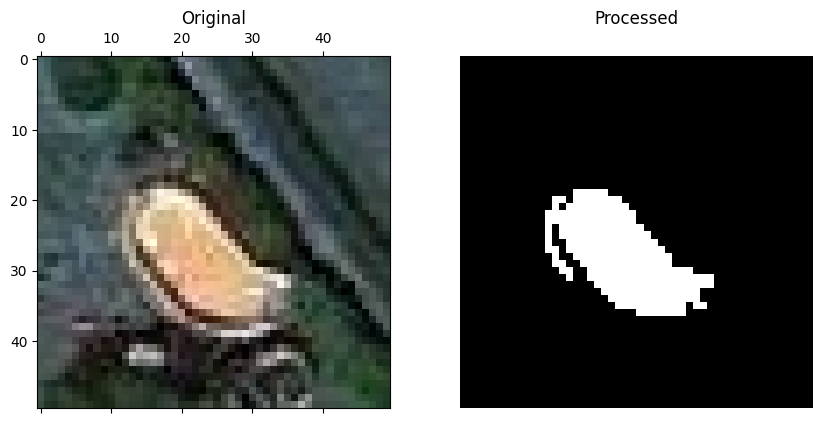

Indice de Jaccard:  0.701067615658363
Cobertura de imagen: 0.8140495867768595


In [186]:
pipe2 = pipeline()
pipe2.add_operation(kmeans_segmentation)
pipe2.add_operation(otsu_threshold)
pipe2.add_operation(morfology_cleaning)
binary = pipe2.apply(imag, False)

display_image_mask(imag, binary, title=pipe2)

print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

#### Seleccion por componente "más azul"

Una de las estrategias tomadas para decidir la componente correcta fue elegir la que tuviera mayor intersección con las zonas azules de la imagen, que dada la naturaleza del problema son las que tienen mayor probabilidad de incluir una piscina. Esto se hizo operando en el espacio de color HSV, en que se definió un rango de posibles "tonos azules" en la imagen que incluyan las piscinas buscadas en colores azules de diferente brillo y saturación (ver función $\texttt{keep\_blue}$). Luego, se calculó la intersección de cada componente con este rango, y se eligió la componente con mayor intersección. Esto se puede observar en la celda siguiente, en que se muestra el promedio del indice de Jaccard calculado para los resultados obtenidos usando este método, variando el valor de k en k-means. 

En principio parece que se obtienen valores peores de cobertura para todos los valores de k, pero se observa también que esto se debe a que el método implementado en este caso es considerablemente más restrictivo que el anterior, ya que por ejemplo presenta más casos en que se descartan todas las componentes. Como se observará a continuación también, este método presenta un máximo local alrededor de k=4, pero este valor no lleva necesariamente a mejores resultados. 

img0.jpg
img1.jpg
img2.jpg
img4.jpg
img5.jpg
img6.jpg
img7.jpg
img8.jpg
img9.jpg
img10.jpg
img11.jpg
img12.jpg
img13.jpg
img14.jpg
img15.jpg
img16.jpg
img17.jpg
img18.jpg
img19.jpg
img20.jpg
no mask


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


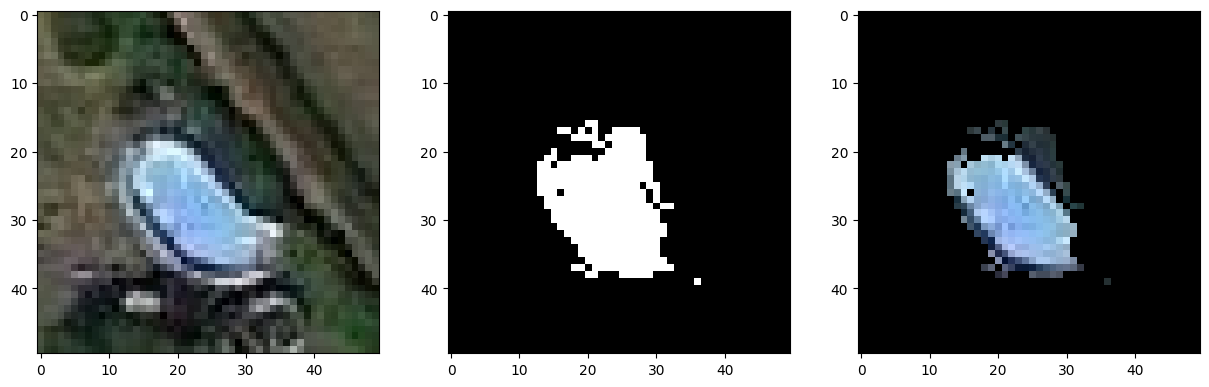

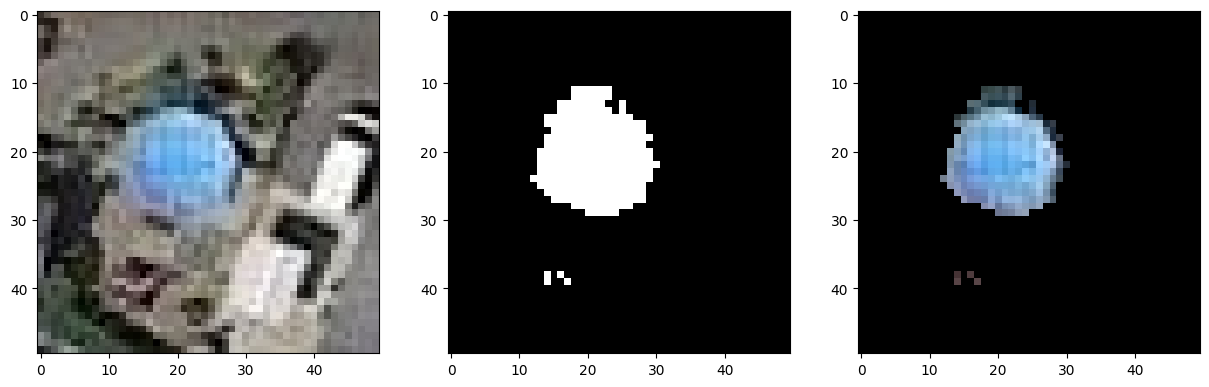

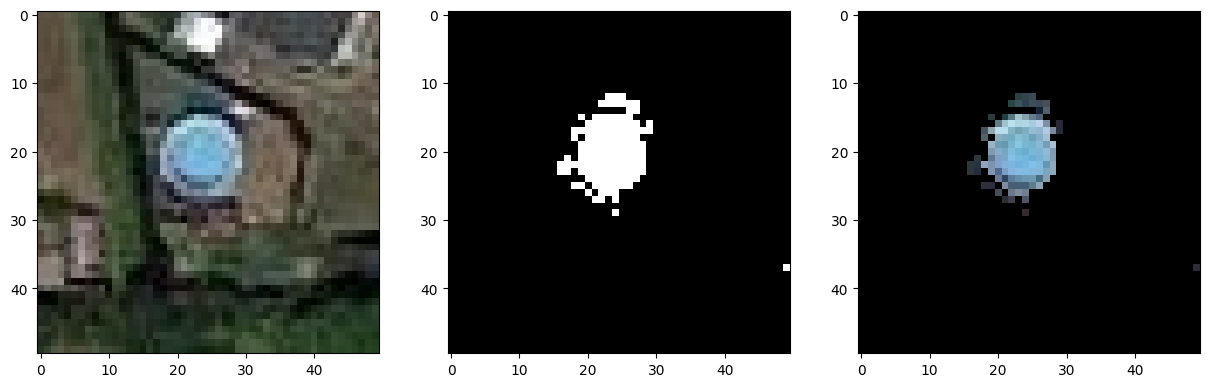

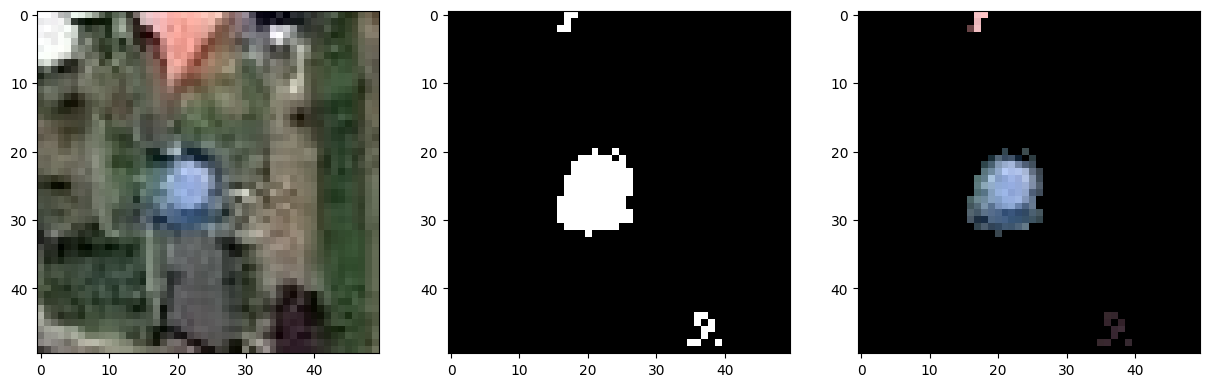

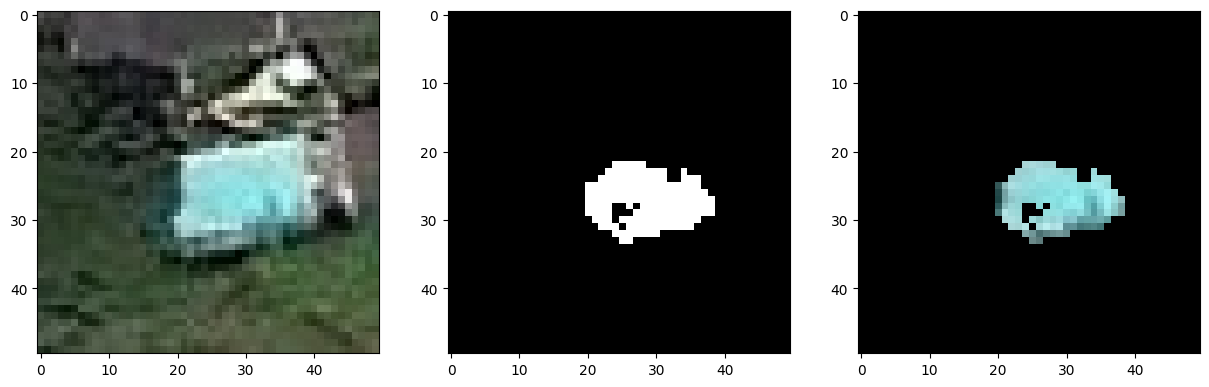

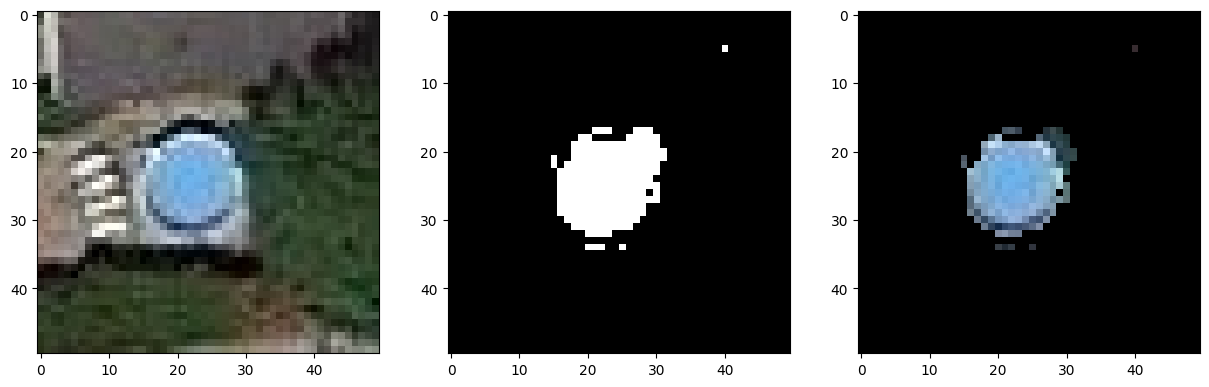

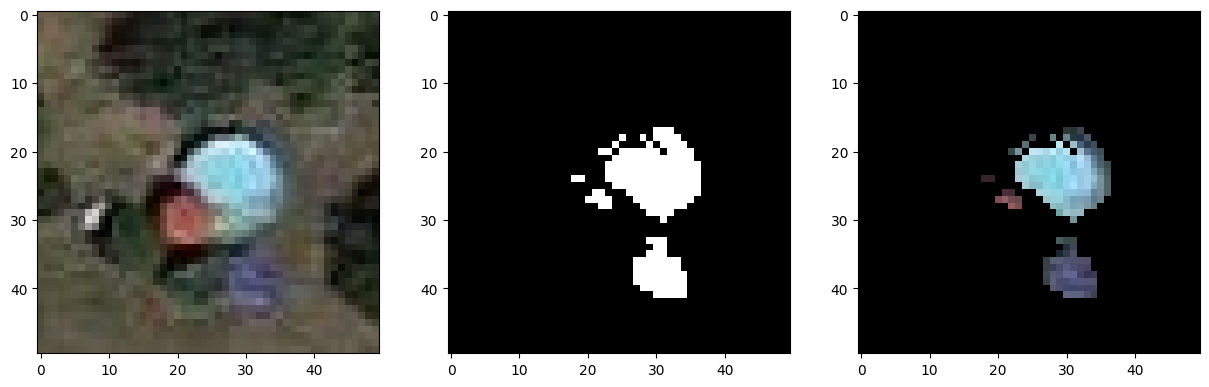

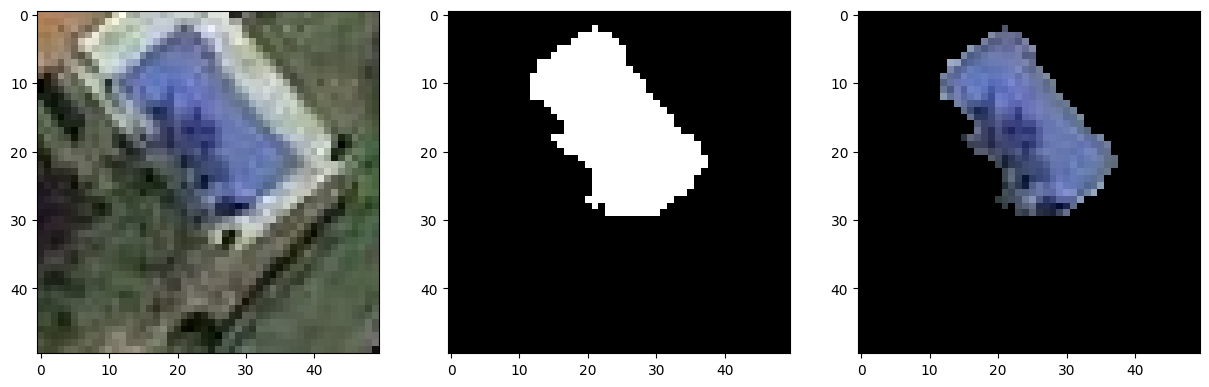

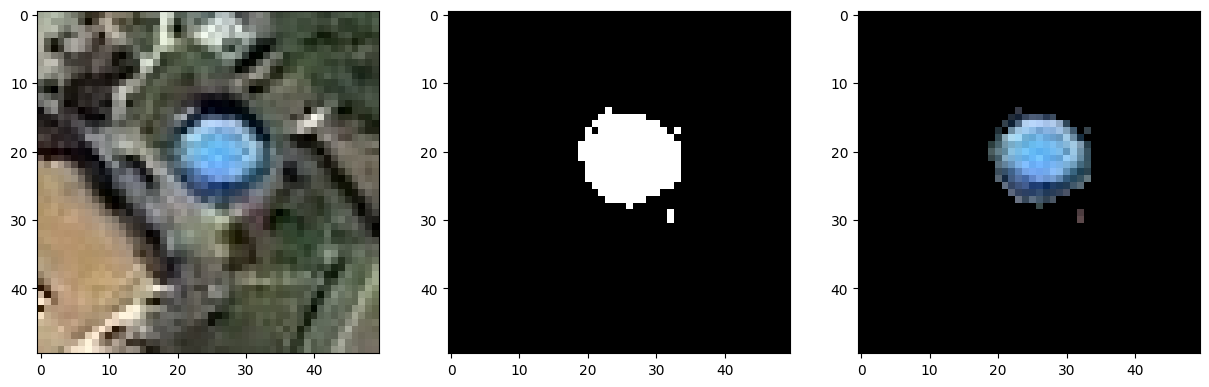

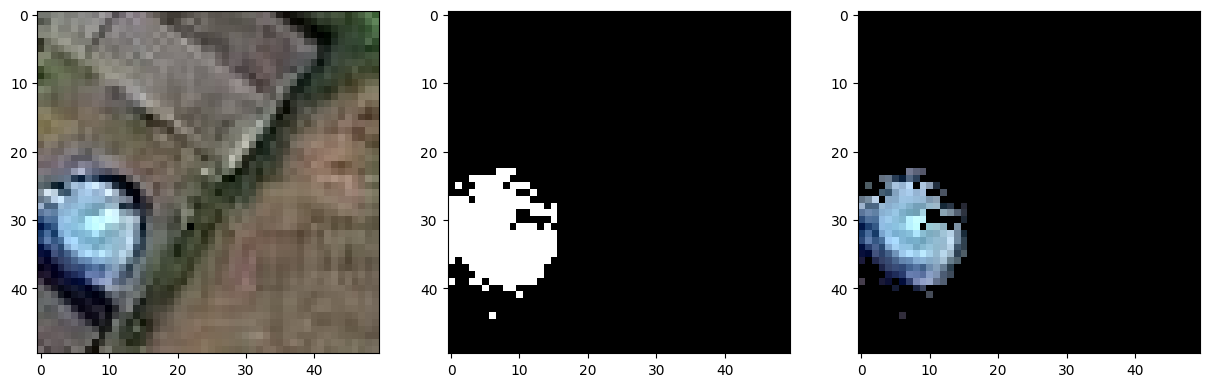

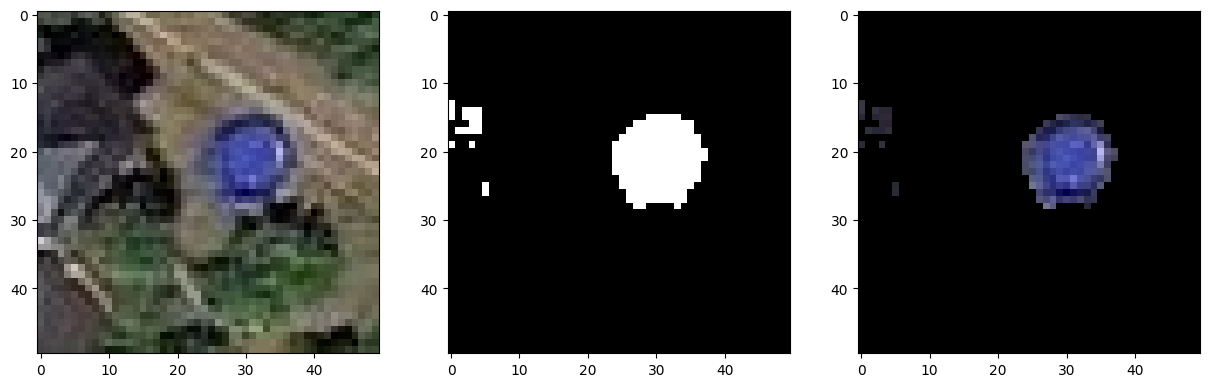

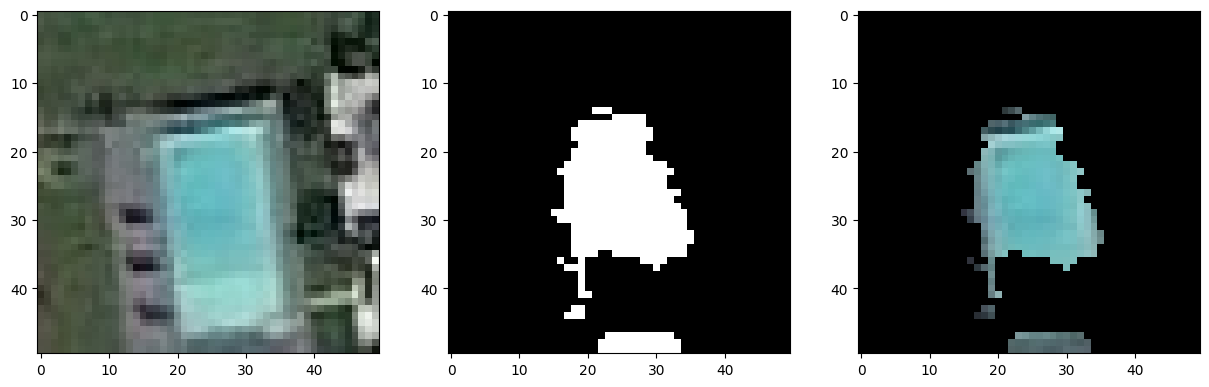

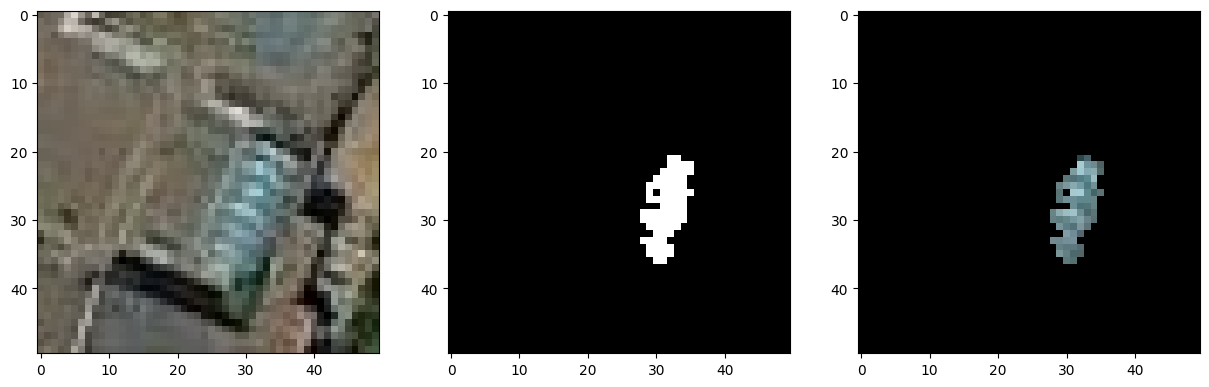

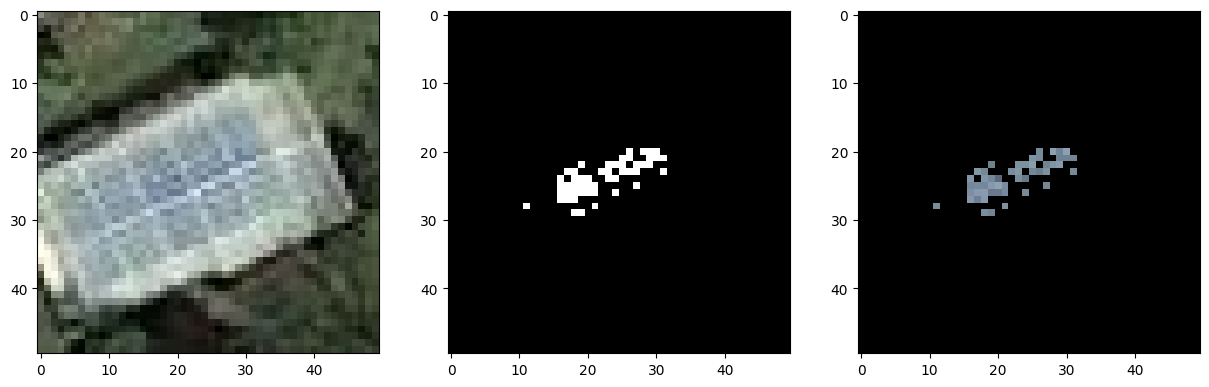

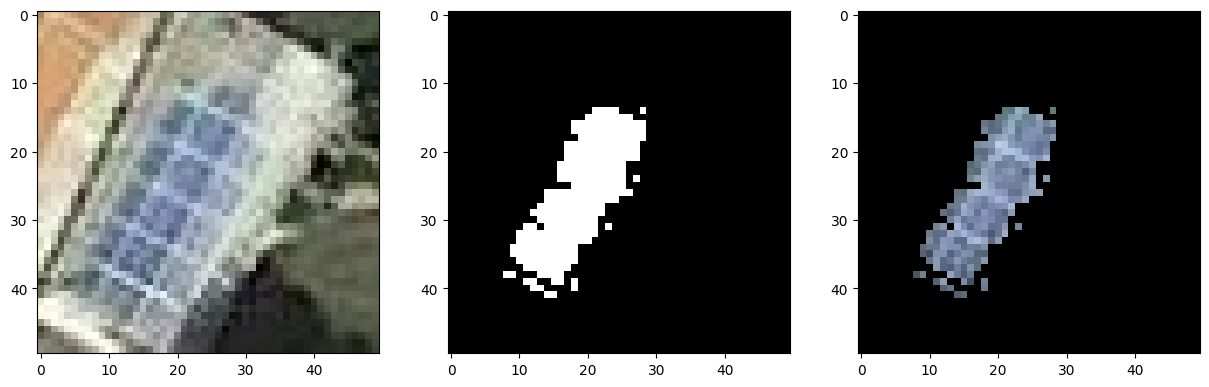

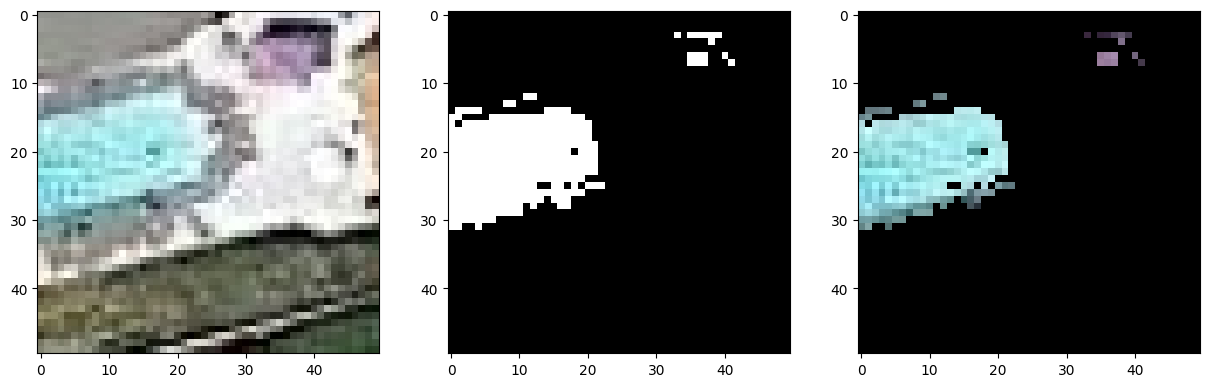

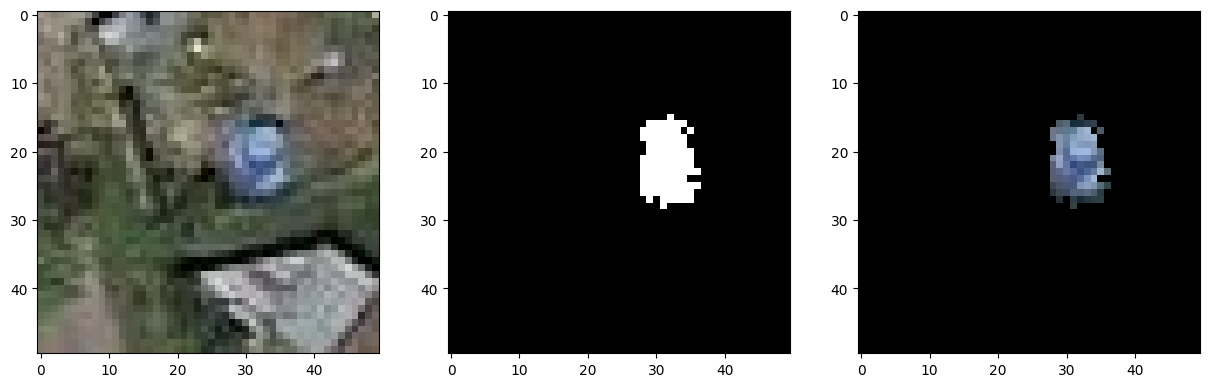

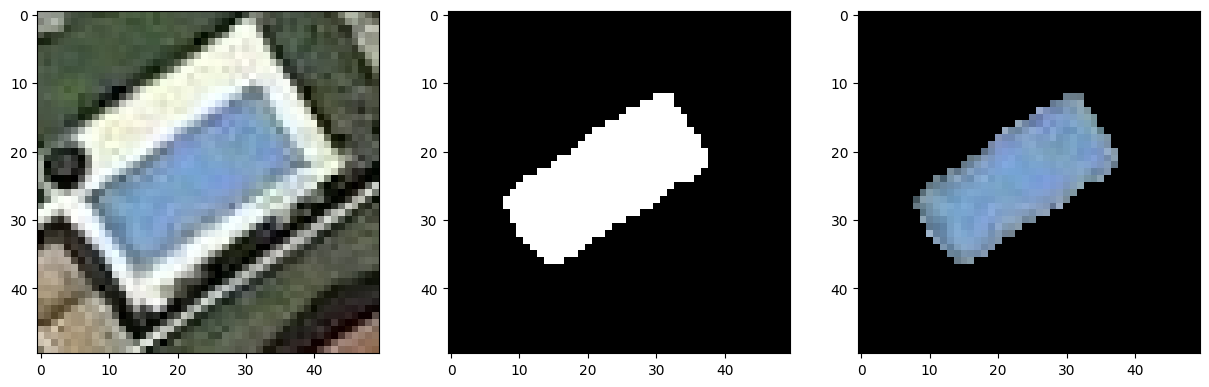

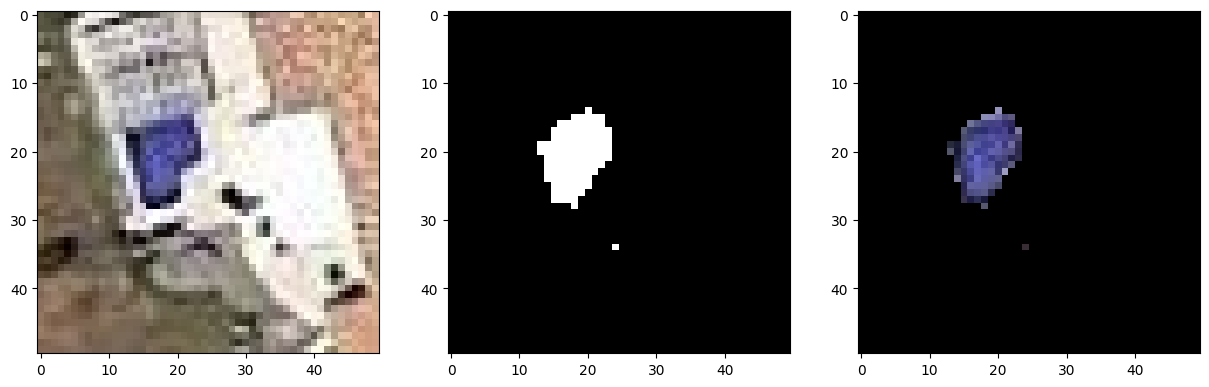

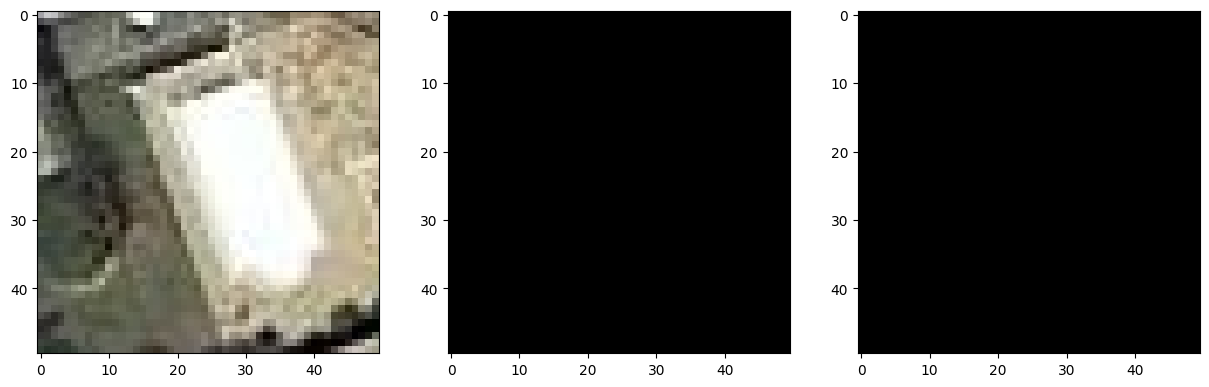

In [224]:
def test_k_iterative_mask_result(results_path, k_min, k_max, get_pipeline):
    resultados = []
    pd.set_option('display.precision', 4)
    df = pd.DataFrame(columns=['k', 'mean', 'std', 'max', 'min'])
    for k in range(k_min, k_max):
        pipe = get_pipeline(k)
        resultados_k = test_mask_results(results_path, pipe)
        df.loc[len(df)] = {'k': k, 'mean': np.mean(resultados_k), 'std': np.array(resultados_k).std(), 'max': np.max(resultados_k), 'min': np.min(resultados_k)}
        resultados.append(resultados_k)
    print(df.to_string(index= False))
    return np.array(resultados)

def pipeline_given_k(k):
    pipe = pipeline()
    pipe.add_operation(partial(kmeans_segmentation2, k=k))
    pipe.add_operation(keep_most_blue_component)
    pipe.add_operation(to_grayscale)
    pipe.add_operation(simple_threshold) #TODO: VER QUE HACER ESTE PIPELINE
    return pipe

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative_mask_result(results_path, 2, 15, pipeline_given_k)

#### Experimento sobre todas las imagnes

Como se observa en la celda anterior, el promedio del indice de Jaccard obtenido no mejora significativamente al aumentar la cantidad de centros usados en k-means, aunque presenta un máximo local alrededor de k=9. Esto tiene sentido teórico ya que en comparación a los casos de k bajos, es más probable al dividir la imagen en más componentes que una de ellas sea la correspondiente a la piscina, pero también es más probable que la componente elegida no sea la correcta. Puede verse en la celda siguiente que no se da necesariamente una mejora al aumentar k si no se toman medidas adicionales para seleccionar la componente correcta.

In [ ]:
def pipeline_given_k_kmeans_otsu(k):
    pipe = pipeline()
    pipe.add_operation(partial(kmeans_segmentation, k=k))
    pipe.add_operation(otsu_threshold)
    pipe.add_operation(morfology_cleaning)
    return pipe

results_path = os.path.join('..', 'results', 'pool_annotation_train_img-0-30.csv')
test = test_k_iterative_mask_result(results_path, 2, 15, pipeline_given_k_kmeans_otsu)

 k   mean    std    max  min
 2 0.3345 0.2457 0.7975  0.0
 3 0.3173 0.2580 0.7834  0.0
 4 0.3099 0.2382 0.7753  0.0
 5 0.2974 0.2254 0.7385  0.0
 6 0.2905 0.2333 0.7809  0.0
 7 0.3245 0.2482 0.8773  0.0
 8 0.3034 0.2658 0.8810  0.0
 9 0.2985 0.2110 0.6983  0.0
10 0.3143 0.2286 0.8123  0.0
11 0.3152 0.2323 0.8025  0.0
12 0.3253 0.2314 0.7181  0.0
13 0.3394 0.2388 0.8218  0.0
14 0.3267 0.2300 0.7210  0.0


#### Ejemplos de casos que fallan

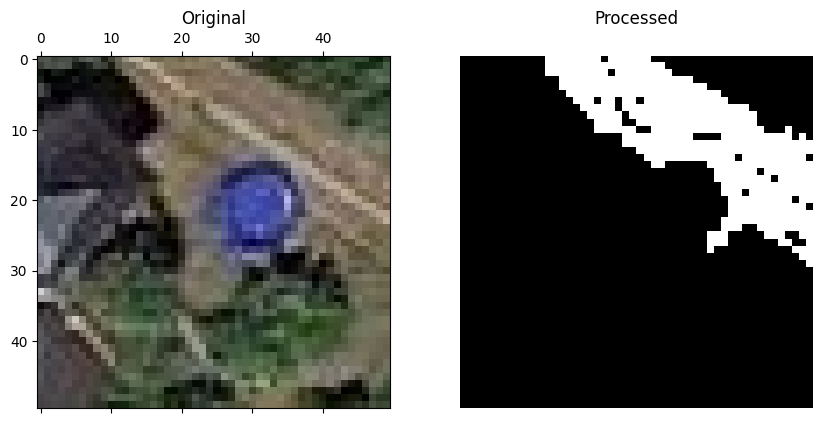

Area:  461.0
Perimeter:  189.78784258493008
Eccentricity:  0.9417369278093655
Equivalent Diameter:  24.22732816723524
Indice de Jaccard:  0.026936026936026935
Cobertura de imagen: 0.10738255033557047


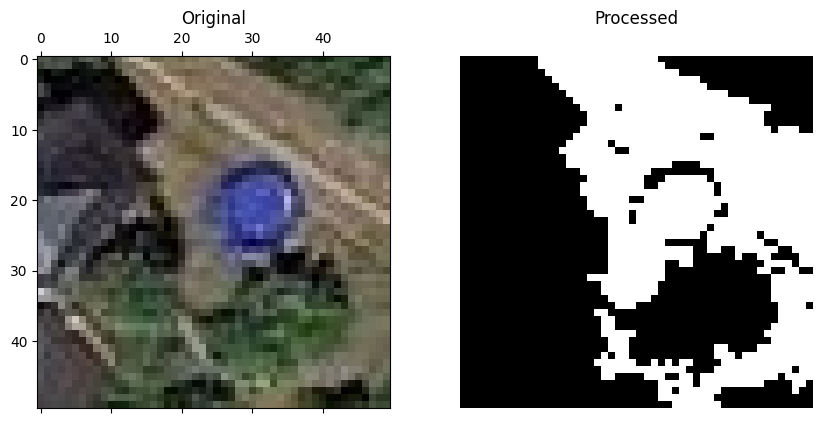

Area:  1037.0
Perimeter:  369.048773235279
Eccentricity:  0.7562043877056284
Equivalent Diameter:  36.33661249883324
Indice de Jaccard:  0.10531220876048462
Cobertura de imagen: 0.7583892617449665


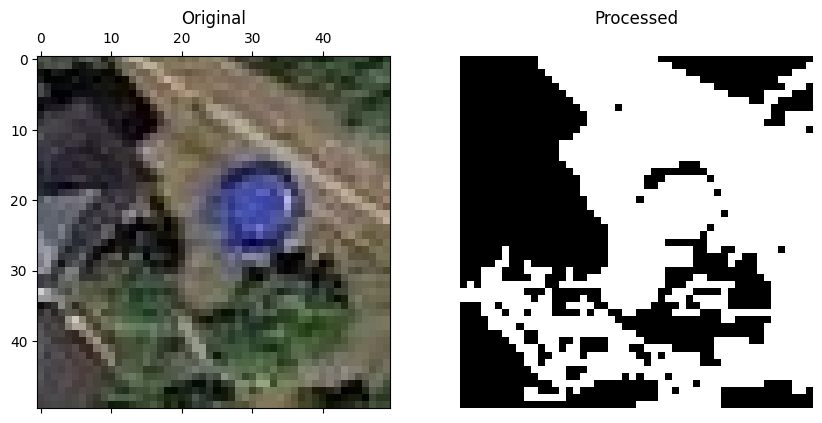

Indice de Jaccard:  0.08304011259676285
Cobertura de imagen: 0.7919463087248322


In [ ]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img11.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img11.jpg', results_path, gray.shape)

binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_k_7 = pipeline()
pipe_k_7.add_operation(partial(kmeans_segmentation, k=9))
pipe_k_7.add_operation(otsu_threshold)
pipe_k_7.add_operation(morfology_cleaning)
binary = pipe_k_7.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

pipe_inter_k_7 = pipeline()
pipe_inter_k_7.add_operation(partial(interpolate_image_size, prop_size=4, interpolation=cv2.INTER_CUBIC))
pipe_inter_k_7.add_operation(partial(kmeans_segmentation, k=9))
pipe_inter_k_7.add_operation(otsu_threshold)
pipe_inter_k_7.add_operation(morfology_cleaning)
binary = pipe_inter_k_7.apply(imag, False)
#binary = interpolate_image_size(binary, prop_size=0.25, interpolation=cv2.INTER_CUBIC)
display_image_mask(image_rgb, binary)
#print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

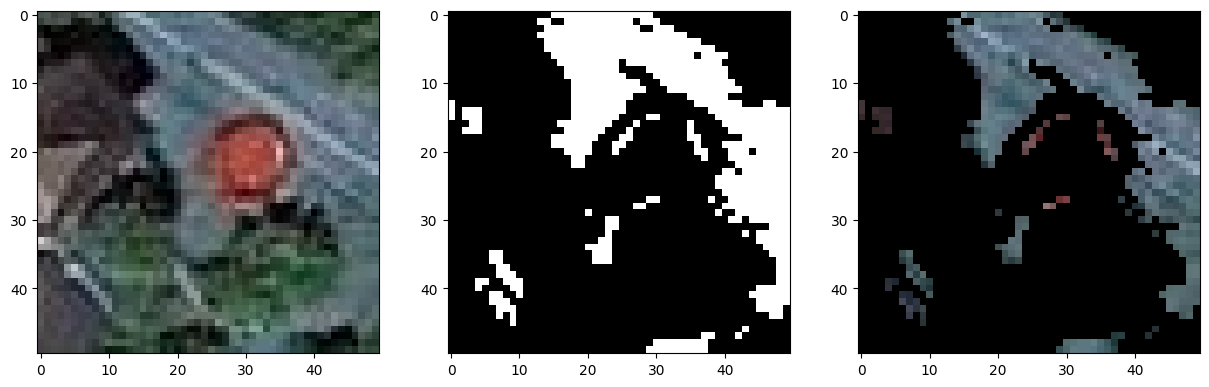

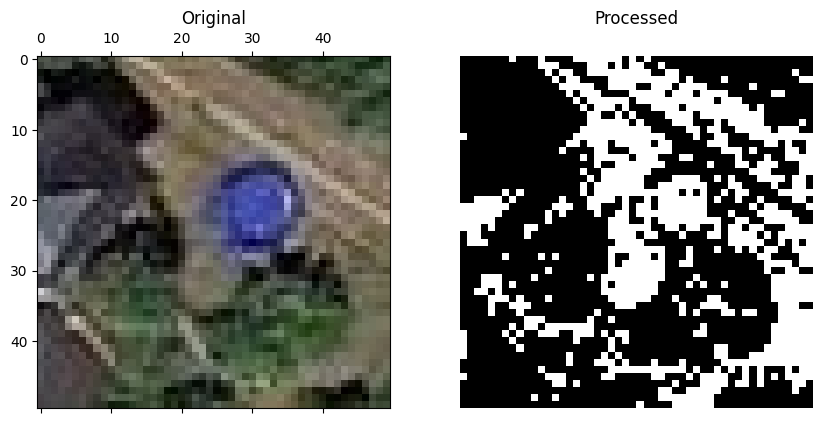

Indice de Jaccard:  0.07513227513227513
Cobertura de imagen: 0.47651006711409394


In [213]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img11.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img11.jpg', results_path, gray.shape)

pipe_keep_most_blue = pipeline()
pipe_keep_most_blue.add_operation(partial(kmeans_segmentation2, k=4))
pipe_keep_most_blue.add_operation(keep_most_blue_component)
#pipe_keep_most_blue.add_operation(otsu_threshold)
pipe_keep_most_blue.add_operation(to_grayscale)
pipe_keep_most_blue.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
#print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

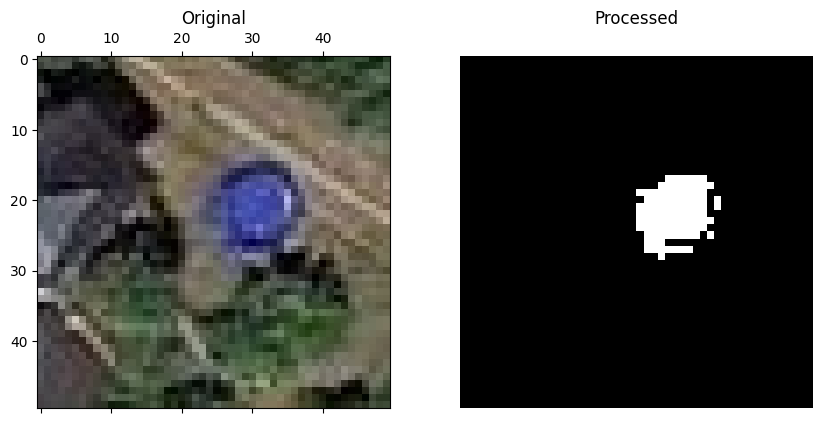

Indice de Jaccard:  0.5408805031446541
Cobertura de imagen: 0.5771812080536913


In [ ]:
pipe_keep_most_blue = pipeline()
pipe_keep_most_blue.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue.add_operation(keep_most_blue_component)
#pipe_keep_most_blue.add_operation(otsu_threshold)
pipe_keep_most_blue.add_operation(to_grayscale)
#pipe_keep_most_blue.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
#print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En el caso anterior se observa entonces como un valor mayor de k permite la segmentación en componentes más precisas, pero esto también lleva a una mayor granularidad en la segmentación, lo que puede llevar a que la componente elegida pierda cierta cantidad de detalles que disminuyen el indice de Jaccard obtenido por cubrir menos partes de la piscina deseada. Sin embargo esto sigue siendo mejor que el caso en que se usa un valor de k menor, ya que en este caso se pierde precisión en la segmentación, lo que lleva a que la componente elegida incluya una gran cantidad de secciones no deseadas.

Puede verse incluso que la mayor presición en la segmentación obtenida lleva a invalidar las operaciones de eliminación de ruido, ya que en este caso se obtienen componentes demasiado pequeñas que son eliminadas por el filtro de tamaño mínimo o el filtro de otsu, como puede verse en las celdas siguientes. En el caso del filtro de tamaño mínimo esto podría ajustarse cambiando el tamaño de la componente mínima, pero intentar calibrar este valor en función del conjunto de datos para obtener mejores resultados sería una solución muy cercana al sobreajuste. Una operación análoga no es posible en el caso del filtro de otsu, ya que este depende de la imagen y no de la componente. 

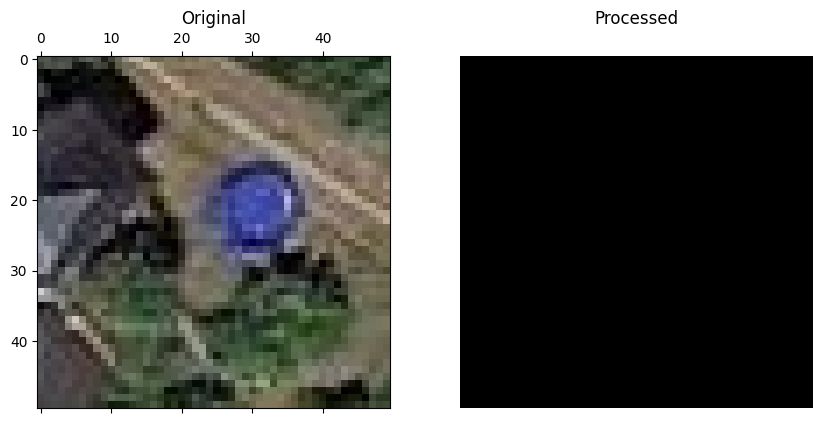

Indice de Jaccard:  0.0
Cobertura de imagen: 0.0


In [ ]:
pipe_keep_most_blue_clean = pipeline()
pipe_keep_most_blue_clean.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_clean.add_operation(keep_most_blue_component)
#pipe_keep_most_blue_clean.add_operation(otsu_threshold)
pipe_keep_most_blue_clean.add_operation(to_grayscale)
pipe_keep_most_blue_clean.add_operation(morfology_cleaning)
binary = pipe_keep_most_blue_clean.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

Por las celdas anteriores se distingue entonces que el método de selección de componente "más azul" es más restrictivo en los resultados obtenidos, y por más que este sea más preciso en cuanto a la posición y forma general de la componente correspondiente a la piscina, este método tiende a descartar secciones deseadas de dicha componente, generando "huecos" que empeoran la cobertura obtenida. Una posible solución a este problema es expandir la selección obtenida y luego erosionarla para rellenar estos "huecos". Como puede verse en los ejemplos a continuación esto lleva a una mejor cobertura, pero sin salirse de la misma región que se obtenía con el método anterior.

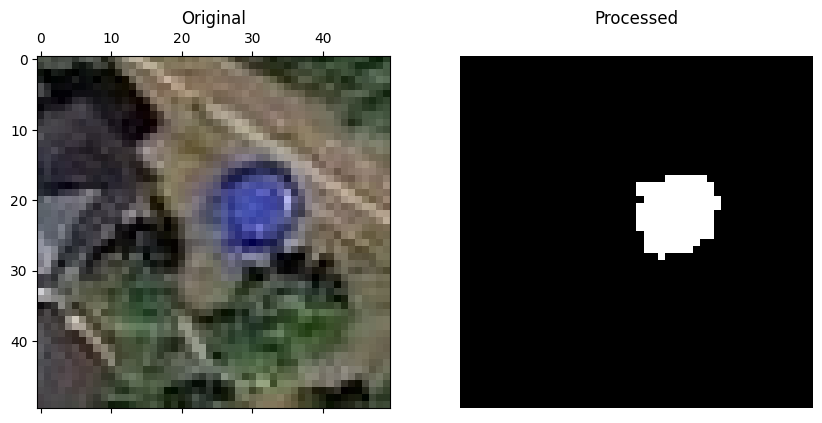

Indice de Jaccard:  0.61875
Cobertura de imagen: 0.6644295302013423


In [ ]:
pipe_keep_most_blue_absorb = pipeline()
pipe_keep_most_blue_absorb.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_absorb.add_operation(keep_most_blue_component)
pipe_keep_most_blue_absorb.add_operation(to_grayscale)
pipe_keep_most_blue_absorb.add_operation(morfology_absorption)
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

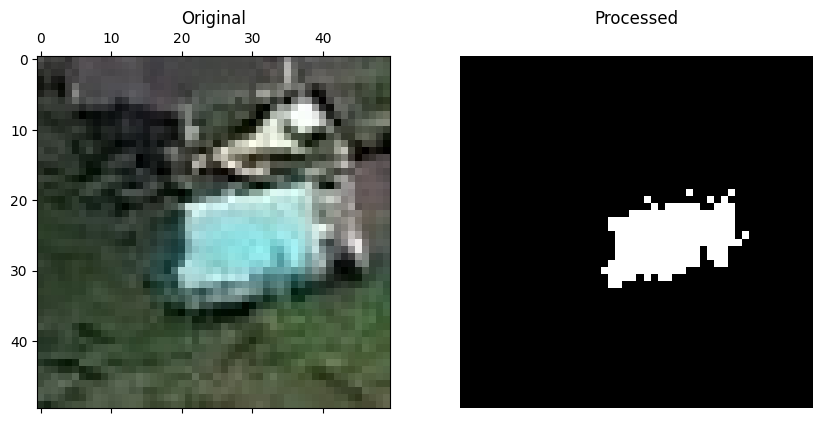

Area:  166.0
Perimeter:  59.2842712474619
Eccentricity:  0.8539540239203088
Equivalent Diameter:  14.538148590038452
Indice de Jaccard:  0.649402390438247
Cobertura de imagen: 0.659919028340081


In [ ]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img5.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img5.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

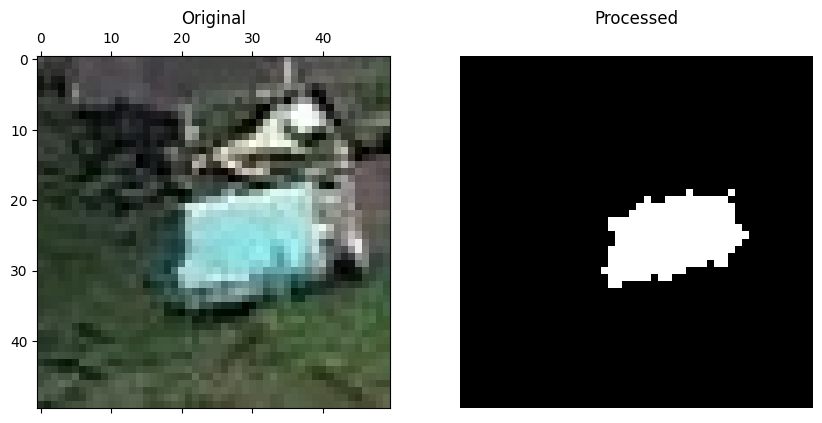

Area:  188.0
Perimeter:  59.94112549695428
Eccentricity:  0.8358251148187497
Equivalent Diameter:  15.471555655790098
Indice de Jaccard:  0.7261904761904762
Cobertura de imagen: 0.7408906882591093


In [ ]:
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

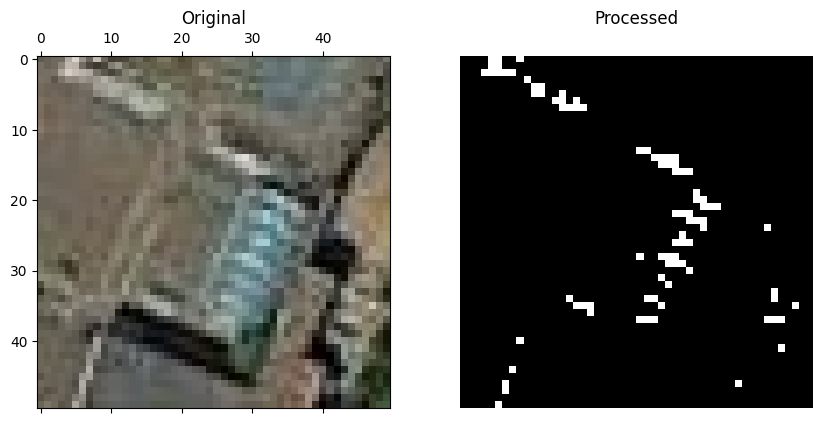

Area:  12.0
Perimeter:  9.414213562373096
Eccentricity:  0.9732290573175456
Equivalent Diameter:  3.9088200952233594
Indice de Jaccard:  0.11808118081180811
Cobertura de imagen: 0.14814814814814814


In [ ]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img13.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img13.jpg', results_path, gray.shape)

binary = pipe_keep_most_blue.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

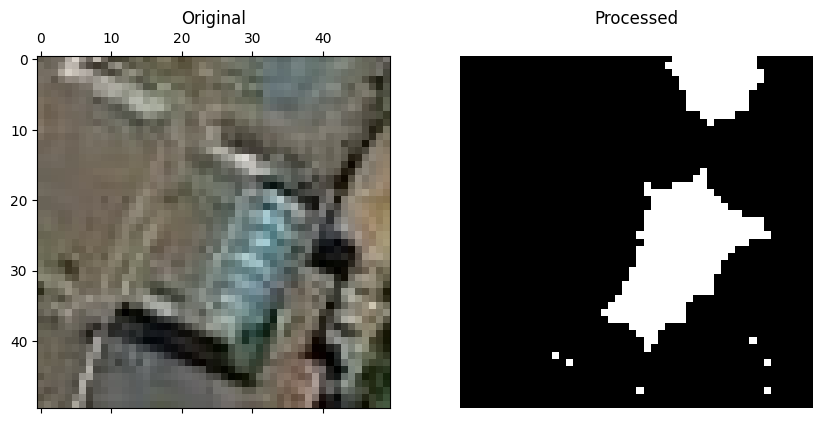

Area:  268.0
Perimeter:  79.84062043356595
Eccentricity:  0.8261471074010273
Equivalent Diameter:  18.47236308621676
Indice de Jaccard:  0.5051546391752577
Cobertura de imagen: 0.9074074074074074


In [ ]:
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

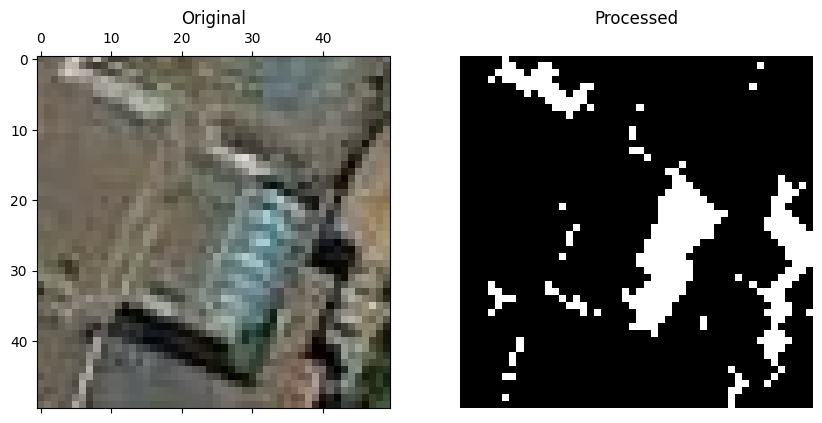

Indice de Jaccard:  0.29603729603729606
Cobertura de imagen: 0.5879629629629629


In [ ]:
pipe_keep_most_blue_absorb = pipeline()
pipe_keep_most_blue_absorb.add_operation(partial(kmeans_segmentation2, k=8))
pipe_keep_most_blue_absorb.add_operation(keep_most_blue_component)
pipe_keep_most_blue_absorb.add_operation(to_grayscale)
pipe_keep_most_blue_absorb.add_operation(partial(morfology_absorption, size=2))
binary = pipe_keep_most_blue_absorb.apply(image_rgb, False)
display_image_mask(image_rgb, binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

En los ejemplos anteriores puede verse también como esta técnica mejora los resultados en los casos en que la piscina no es de color azul completamente, ya que en estos casos el método rellena los huecos que este tipo de piscinas causan en las componentes halladas mediante k-means.

### COMPARACION

En este caso pueden verse en orden los resultados de aplicar a una misma imagen los diferentes algoritmos de segmentación, con sus respectivos parámetros.

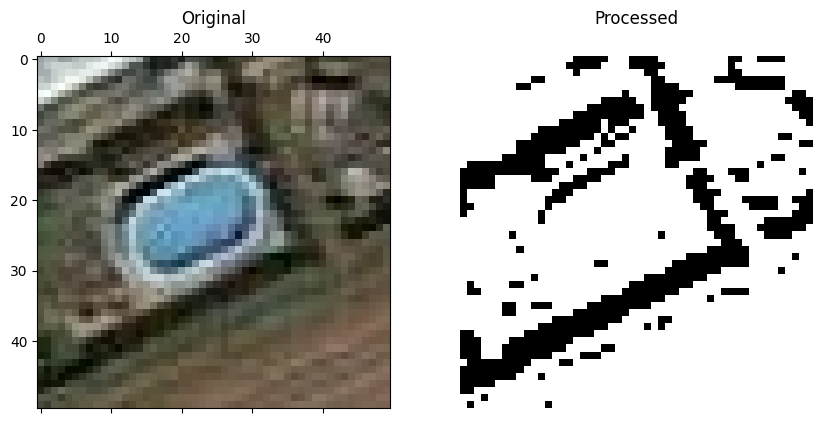

Area:  1923.0
Perimeter:  670.3574311003804
Eccentricity:  0.39540260553918344
Equivalent Diameter:  49.48171020211122
Indice de Jaccard:  0.10482615464452517
Cobertura de imagen: 0.9853658536585366


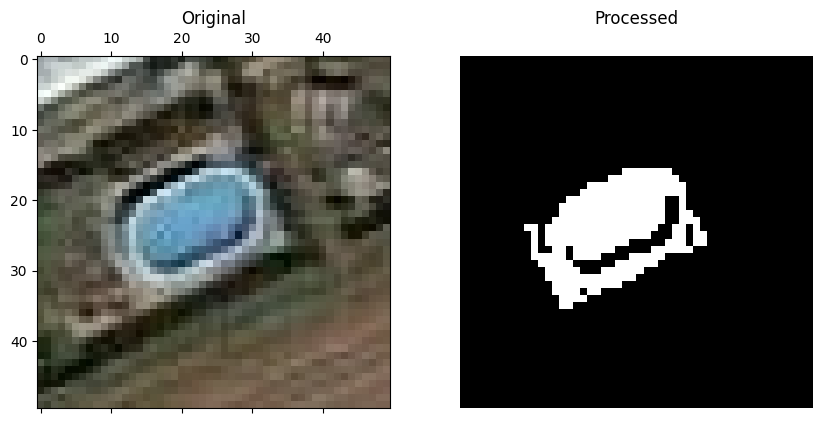

Area:  258.0
Perimeter:  124.32590180780451
Eccentricity:  0.7838185299419198
Equivalent Diameter:  18.12445316531431
Indice de Jaccard:  0.5536912751677853
Cobertura de imagen: 0.8048780487804879


In [ ]:
imag = cv2.imread(os.path.join(TRAIN_DIR, 'pools', 'img29.jpg'))
image_rgb = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(imag, cv2.COLOR_BGR2GRAY)

mask = obtain_measured_mask('img29.jpg', results_path, gray.shape)

binary = pipe1.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

binary = pipe2.apply(imag, False)
display_image_mask(image_rgb, binary)
print_metrics(binary)
print('Indice de Jaccard: ', jaccard_index(mask, binary))
print('Cobertura de imagen:', image_matching(binary, mask))

### COMENTAR PROBLEMAS, DIFICULTADES, ETC (agregar ejemplos si vale la pena)

## MEDICIONES SOBRE MASCARAS